## Carbon Footprint Assessment:
Develop a metric for evaluating building carbon footprints, accounting for energy and water consumption, size, and other factors.

In [90]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json


In [91]:
# Load the schema from the JSON file
with open('./data/schema_cleaned2.json') as schema_file:
    schema = json.load(schema_file)

# Convert schema to the format required by pandas
# Note: In this case, we're assuming all the dtypes are compatible with pandas dtypes.
# If there are any discrepancies, you may need to manually adjust the dtypes.
pandas_schema = {key: value for key, value in schema.items()}
feature_list = [key for key, value in schema.items()]

## Data Preparation
Since not all our data is numerical, we'll need to do some one-hot encoding.
Given all the categorical columns, we're going to use pandas library for one-hot encoding.

In [108]:
# Now read the cleaned CSV file using the schema
df_cleaned = pd.read_csv('./data/data_cleaned2.csv', dtype=pandas_schema)

# Select the categorical columns that need one-hot encoding
categorical_columns = [key for key, value in schema.items() if value == 'object']
numerical_columns = [key for key, value in schema.items() if value == 'float64']

print(categorical_columns)
# Perform one-hot encoding on the selected columns, and will be used for K-Means
# data_encoded_categorical = pd.get_dummies(df_cleaned, columns=categorical_columns)  # Perform one-hot encoding
# data_encoded_numerical = pd.get_dummies(df_cleaned, columns=numerical_columns)  # Perform one-hot encoding


['year_ending', 'nyc_borough_block_and_lot', 'address_1', 'postal_code', 'primary_property_type_self', 'national_median_reference', 'construction_status', 'metered_areas_energy', 'energy_star_certification_1', 'estimated_values_energy', 'estimated_values_water', 'alert_data_center_issue_with', 'alert_energy_meter_has_less', 'alert_energy_meter_has_gaps', 'alert_energy_meter_has', 'alert_energy_no_meters', 'alert_energy_meter_has_single', 'alert_water_meter_has_less', 'alert_property_has_no_uses', 'default_values', 'temporary_values', 'last_modified_date_property', 'last_modified_date_property_1', 'generation_date', 'submission_date']


In [118]:
# Function to calculate target means for each category
def calculate_target_means(df, categorical_columns, target_column):
    target_means = df.groupby(categorical_columns)[target_column].mean()
    return target_means

# Function to apply target encoding
def apply_target_encoding(df, categorical_columns, target_column, target_means):
    for col in categorical_columns:
        df[col] = df[col].map(target_means)
        print(f"df[{col}] = {df[col].map(target_means)}")
    
    # Rename the new column with the target means
    df.rename(columns={target_column+'_mean': target_column}, inplace=True)


## Target Encoding or Mean Encoding
Convert categorical variables into numerical representations by encoding them with the mean of the target variable for each category. This can capture the relationship between the categorical feature and the target variable.

In [129]:
# Calculate the mean target for each category in the categorical columns
target_means = df_cleaned.groupby(categorical_columns)['net_emissions_metric_tons'].mean().reset_index()

# Merge the target means back into the original DataFrame based on the categorical columns
df_with_target_means = pd.merge(df_cleaned, target_means, on=categorical_columns, how='left')

# Rename the column with the mean target values
df_with_target_means.rename(columns={'net_emissions_metric_tons_x': 'net_emissions_metric_tons', 'net_emissions_metric_tons_y': 'mean_target'}, inplace=True)

# Fill NaN values in the 'mean_target' column with 0
df_with_target_means.fillna(0,  inplace=True)

# Convert all columns to float64
df_with_target_means = df_with_target_means.astype(float)

# Now, df_with_target_means contains the mean target value for each row based on the categorical columns,
# and all columns are of type float64
print(df_with_target_means)

       property_id  year_ending  nyc_borough_block_and_lot  address_1  \
0       21205224.0          0.0                        0.0        0.0   
1        2665352.0          0.0                        0.0        0.0   
2        2665400.0          0.0                        0.0        0.0   
3        2665405.0          0.0                        0.0        0.0   
4        2665415.0          0.0                        0.0        0.0   
...            ...          ...                        ...        ...   
18317    6575086.0          0.0                        0.0        0.0   
18318    6575119.0          0.0                        0.0        0.0   
18319    6575799.0          0.0                        0.0        0.0   
18320    6576684.0          0.0                        0.0        0.0   
18321    2813826.0          0.0                        0.0        0.0   

       postal_code  primary_property_type_self  national_median_reference  \
0              0.0                         0.0

## Feature Selection & Scaling
Choosing the relevant features for clustering the different types of buildings

In [130]:
# Scale our data for a mean of 0
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_with_target_means)

In [131]:
# Perform dimensionality reduction using PCA
num_components = 15
pca = PCA(n_components=num_components)  # Adjust the number of components as needed
reduced_features = pca.fit_transform(df_with_target_means)

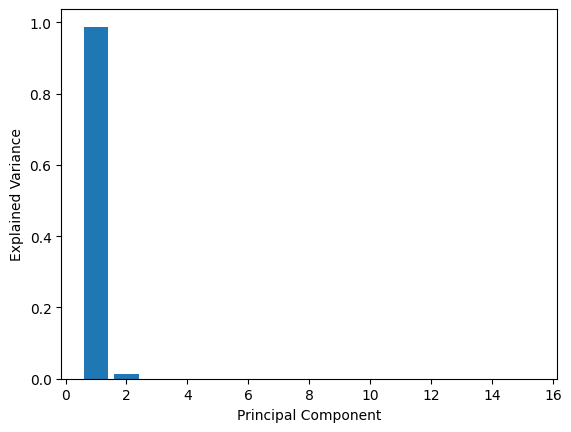

In [132]:
# Fit the PCA model to your data
pca.fit(df_with_target_means)

# Get the transformed data (principal components)
components = pca.transform(df_with_target_means)

# Calculate the explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance to decide on the number of components to keep
plt.bar(range(1, num_components + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [136]:
# Now, you can examine which original features contribute most to the first few components
feature_contributions = abs(pca.components_[num_components - 1])
sorted_features = sorted(zip(df_with_target_means.columns, feature_contributions), key=lambda x: -x[1])

# Print the most important features for the chosen component
print(f"Most important features for Principal Component {num_components}:")
print(feature_contributions)
contributions = {}
count = 0
for feature, contribution in sorted_features:
    print(f"{feature}: {contribution:.2f}")

Most important features for Principal Component 15:
[1.78054580e-07 1.36015036e-19 5.28275929e-20 2.29746091e-19
 1.02938681e-19 5.50295659e-20 1.10731377e-18 5.48263464e-06
 1.26603843e-02 2.32476616e-17 8.93483908e-03 9.96785773e-01
 2.87414830e-17 3.51366138e-18 4.24039960e-20 6.38813044e-02
 4.41866493e-02 1.83107683e-04 3.75076304e-04 8.12957551e-03
 3.49018120e-06 3.10071901e-03 8.22497272e-04 7.80472379e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.54677329e-06 2.80315067e-06 0.00000000e+00 0.00000000e+00
 2.69378389e-03 2.08959292e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
occupancy: 1.00
national_median_site_eui: 0.06
national_median_source_eui: 0.04
year_built: 0.01
number_of_buildings: 0.01
egrid_output_emissions_rate: 0.01
multifamily_housing_percent_1: 0.01
multifamily_housing_total: 0.00
number_of_active_energy_meters: 0.0

## K-Means Clustering
After dimensionality reduction, we proceed with K-Means clustering on the reduced feature set. The goal is to cluster data points in this lower-dimensional space into K clusters.

In [137]:
# Choose the number of clusters (K)
K = 3  # Replace with the desired number of clusters

# Create a K-Means model
# kmeans_model = KMeans(n_clusters=K, random_state=42)
kmeans_model = KMeans(n_clusters=K, init='k-means++', random_state=42)

# Fit the K-Means model to the reduced features
kmeans_model.fit(reduced_features)

# Get cluster assignments for each data point in the dataset
cluster_assignments = kmeans_model.predict(reduced_features)

silhouette_avg = silhouette_score(reduced_features, cluster_assignments)
print(f"Silhouette Score: {silhouette_avg}")

/Users/bgutu/Desktop/Fall23/Hackton/DS-Hackathon-Fall-2023/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.6395463485305067


## Plot

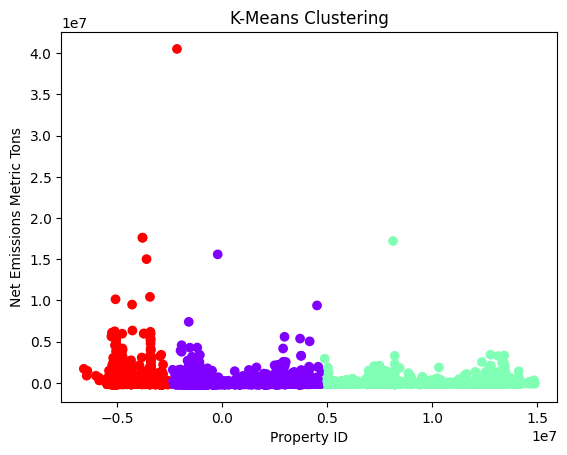

In [139]:
# Create a scatter plot to visualize the clusters
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cluster_assignments, cmap='rainbow')
plt.xlabel('Property Type')
plt.ylabel('Net Emissions Metric Tons')
plt.title('K-Means Clustering')
plt.show()